
## 1. Environment Setup


In [16]:
!pip install -q rdkit torch torchvision torchaudio scikit-learn pandas matplotlib seaborn numpy



## 2. Imports, Configuration, and Utility Setup


Mount Google Drive

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    f1_score,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Plotting defaults
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)


Using device: cuda



## 3. Configuration: CSV Path and Target Task

Set the path to `tox21.csv` and choose the single toxicity endpoint to model.

- I've chose to predict for **SR-p53**.


In [19]:
# Path to the Tox21 CSV file
CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/tox21.csv" 

# Target task name (single binary endpoint)
TARGET_TASK_NAME = "SR-p53"

print("CSV path:", CSV_PATH)
print("Target task:", TARGET_TASK_NAME)


CSV path: /content/drive/MyDrive/Colab Notebooks/tox21.csv
Target task: SR-p53



## 4. Load and Inspect the Tox21 CSV


In [20]:
# Load CSV
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Basic SR-p53 label stats
if TARGET_TASK_NAME not in df.columns:
    raise ValueError(f"Target task {TARGET_TASK_NAME} not found in CSV columns.")

total_rows = len(df)
num_missing = df[TARGET_TASK_NAME].isna().sum()
num_labeled = total_rows - num_missing

print(f"Total rows: {total_rows}")
print(f"Labeled rows for {TARGET_TASK_NAME}: {num_labeled}")
print(f"Missing labels for {TARGET_TASK_NAME}: {num_missing}")


Shape: (7831, 14)
Columns: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53', 'mol_id', 'smiles']
Total rows: 7831
Labeled rows for SR-p53: 6774
Missing labels for SR-p53: 1057



### 4.1. Filter to Labeled Single-Task Data (SR-p53)

We keep only rows where the target task is labeled (0 or 1).


In [21]:
# Keep only rows with non-missing target labels
df_single = df[df[TARGET_TASK_NAME].notna()].copy()
df_single[TARGET_TASK_NAME] = df_single[TARGET_TASK_NAME].astype(int)

print("Filtered single-task dataset shape:", df_single.shape)
print(df_single[["mol_id", "smiles", TARGET_TASK_NAME]].head())


Filtered single-task dataset shape: (6774, 14)
     mol_id                                smiles  SR-p53
0   TOX3021          CCOc1ccc2nc(S(N)(=O)=O)sc2c1       0
1   TOX3020             CCN1C(=O)NC(c2ccccc2)C1=O       0
3   TOX3027       CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C       0
4  TOX20800             CC(O)(P(=O)(O)O)P(=O)(O)O       0
5   TOX5110  CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C       0



## 5. Convert SMILES to Molecular Graphs (RDKit)


In [22]:
def mol_from_smiles(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception:
        mol = None
    return mol

def build_graph_from_mol(mol):
    n_atoms = mol.GetNumAtoms()
    atom_ids = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=np.int64)

    # Adjacency matrix (without self-loops)
    A = np.zeros((n_atoms, n_atoms), dtype=np.float32)
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        A[i, j] = 1.0
        A[j, i] = 1.0

    # Add self-loops
    A_tilde = A + np.eye(n_atoms, dtype=np.float32)

    # Degree normalization: A_hat = D^{-1/2} A_tilde D^{-1/2}
    deg = A_tilde.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(deg + 1e-8))
    A_hat = D_inv_sqrt @ A_tilde @ D_inv_sqrt

    return atom_ids, A_hat

atom_id_list = []
adj_list = []
labels = []
smiles_list = []

num_failed = 0

for idx, row in df_single.iterrows():
    smiles = row["smiles"]
    label = int(row[TARGET_TASK_NAME])
    mol = mol_from_smiles(smiles)
    if mol is None:
        num_failed += 1
        continue
    atom_ids, A_hat = build_graph_from_mol(mol)
    # Skip empty molecules just in case
    if atom_ids.shape[0] == 0:
        num_failed += 1
        continue
    atom_id_list.append(atom_ids)
    adj_list.append(A_hat)
    labels.append(label)
    smiles_list.append(smiles)

print(f"Total labeled rows: {len(df_single)}")
print(f"Molecules successfully featurized: {len(atom_id_list)}")
print(f"Molecules skipped due to SMILES parse issues: {num_failed}")


[05:30:15] WARNING: not removing hydrogen atom without neighbors
[05:30:16] Explicit valence for atom # 3 Al, 6, is greater than permitted
[05:30:16] Explicit valence for atom # 4 Al, 6, is greater than permitted
[05:30:17] Explicit valence for atom # 4 Al, 6, is greater than permitted
[05:30:17] Explicit valence for atom # 9 Al, 6, is greater than permitted
[05:30:17] Explicit valence for atom # 5 Al, 6, is greater than permitted
[05:30:18] Explicit valence for atom # 16 Al, 6, is greater than permitted
[05:30:18] Explicit valence for atom # 20 Al, 6, is greater than permitted


Total labeled rows: 6774
Molecules successfully featurized: 6767
Molecules skipped due to SMILES parse issues: 7



### 5.1. Graph Statistics and Padding


In [23]:
num_graphs = len(atom_id_list)
graph_sizes = np.array([len(ids) for ids in atom_id_list])
max_nodes = int(graph_sizes.max())
min_nodes = int(graph_sizes.min())
mean_nodes = float(graph_sizes.mean())

print(f"Number of graphs: {num_graphs}")
print(f"Min atoms per graph: {min_nodes}")
print(f"Max atoms per graph: {max_nodes}")
print(f"Mean atoms per graph: {mean_nodes:.2f}")

# Determine maximum atomic number (for embedding)
max_atomic_num = int(max([ids.max() for ids in atom_id_list]))
print("Maximum atomic number in dataset:", max_atomic_num)

# Pad atom_ids, A_hat, and build mask
atom_ids_padded = np.zeros((num_graphs, max_nodes), dtype=np.int64)  # 0 = padding
A_padded = np.zeros((num_graphs, max_nodes, max_nodes), dtype=np.float32)
mask_padded = np.zeros((num_graphs, max_nodes), dtype=bool)
labels_array = np.array(labels, dtype=np.int64)

for i, (atom_ids, A_hat) in enumerate(zip(atom_id_list, adj_list)):
    n = atom_ids.shape[0]
    atom_ids_padded[i, :n] = atom_ids
    A_padded[i, :n, :n] = A_hat
    mask_padded[i, :n] = True

print("Padded atom_ids shape:", atom_ids_padded.shape)
print("Padded A_hat shape:", A_padded.shape)
print("Mask shape:", mask_padded.shape)


Number of graphs: 6767
Min atoms per graph: 1
Max atoms per graph: 132
Mean atoms per graph: 17.90
Maximum atomic number in dataset: 83
Padded atom_ids shape: (6767, 132)
Padded A_hat shape: (6767, 132, 132)
Mask shape: (6767, 132)



## 6. Train / Validation / Test Split

Performed a **stratified random split** on the labeled graphs:

- 70% train
- 15% validation
- 15% test


In [24]:
indices = np.arange(num_graphs)
y = labels_array

# Train vs temp (valid + test)
train_idx, temp_idx, y_train, y_temp = train_test_split(
    indices, y, test_size=0.30, stratify=y, random_state=SEED
)

# Valid vs test
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)

print("Train size:", len(train_idx))
print("Valid size:", len(val_idx))
print("Test size:", len(test_idx))

def label_stats(subset_idx, subset_name):
    subset_labels = y[subset_idx]
    pos = subset_labels.sum()
    neg = len(subset_labels) - pos
    print(f"{subset_name}: N={len(subset_labels)}, Pos={pos} ({pos/len(subset_labels):.2%}), Neg={neg} ({neg/len(subset_labels):.2%})" )

label_stats(train_idx, "Train")
label_stats(val_idx, "Valid")
label_stats(test_idx, "Test")


Train size: 4736
Valid size: 1015
Test size: 1016
Train: N=4736, Pos=296 (6.25%), Neg=4440 (93.75%)
Valid: N=1015, Pos=63 (6.21%), Neg=952 (93.79%)
Test: N=1016, Pos=64 (6.30%), Neg=952 (93.70%)



## 7. PyTorch Dataset and DataLoaders


In [25]:
class GraphDataset(Dataset):
    def __init__(self, atom_ids, A_hat, mask, labels, indices):
        self.atom_ids = torch.from_numpy(atom_ids).long()
        self.A_hat = torch.from_numpy(A_hat).float()
        self.mask = torch.from_numpy(mask).bool()
        self.labels = torch.from_numpy(labels).float()
        self.indices = np.array(indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        return (
            self.atom_ids[i],
            self.A_hat[i],
            self.mask[i],
            self.labels[i],
        )

# Create datasets
train_dataset = GraphDataset(atom_ids_padded, A_padded, mask_padded, labels_array, train_idx)
val_dataset = GraphDataset(atom_ids_padded, A_padded, mask_padded, labels_array, val_idx)
test_dataset = GraphDataset(atom_ids_padded, A_padded, mask_padded, labels_array, test_idx)

# DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)


(74, 16, 16)


## 8. Evaluation Metrics

We use:

- AUROC
- AUPRC (Average Precision)
- Accuracy
- F1-score
- Confusion matrix (TP, FP, TN, FN)


In [26]:
def compute_binary_metrics(y_true, y_proba, threshold=0.5):
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)
    y_pred = (y_proba >= threshold).astype(int)

    metrics = {}
    # AUROC
    if len(np.unique(y_true)) > 1:
        metrics["auroc"] = roc_auc_score(y_true, y_proba)
    else:
        metrics["auroc"] = np.nan
    # AUPRC
    try:
        metrics["auprc"] = average_precision_score(y_true, y_proba)
    except ValueError:
        metrics["auprc"] = np.nan

    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["f1"] = f1_score(y_true, y_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics["tn"] = tn
    metrics["fp"] = fp
    metrics["fn"] = fn
    metrics["tp"] = tp
    return metrics

def evaluate_model(model, data_loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for atom_ids, A_hat, mask, labels in data_loader:
            atom_ids = atom_ids.to(device)
            A_hat = A_hat.to(device)
            mask = mask.to(device)
            labels = labels.to(device)

            logits = model(atom_ids, A_hat, mask)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_proba = np.concatenate(all_probs)
    return compute_binary_metrics(y_true, y_proba, threshold=0.5)



## 9. GNN Model: Simple GCN-Style Network

We implement a basic **GCN-like** architecture:

- Embedding layer maps atomic numbers to dense vectors.
- Several graph convolution layers: \( H^{(l+1)} = \text{ReLU}(\hat{A} H^{(l)} W^{(l)}) \).
- Masked mean pooling over nodes.
- Final linear layer to output a single logit per graph.


In [27]:
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, X, A_hat):
        # X: (B, N, in_dim), A_hat: (B, N, N)
        H = self.linear(X)          
        H = torch.bmm(A_hat, H)     
        return torch.relu(H)

class GraphClassifier(nn.Module):
    def __init__(self, num_atom_types, embed_dim=64, hidden_dim=64, n_layers=3, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(num_atom_types, embed_dim)
        layers = []
        in_dim = embed_dim
        for _ in range(n_layers):
            layers.append(GCNLayer(in_dim, hidden_dim))
            in_dim = hidden_dim
        self.gcn_layers = nn.ModuleList(layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, atom_ids, A_hat, mask):
        # atom_ids: (B, N), A_hat: (B, N, N), mask: (B, N)
        X = self.embedding(atom_ids)         
        H = X
        for gcn in self.gcn_layers:
            H = gcn(H, A_hat)
            H = self.dropout(H)

        # Masked mean pooling
        mask_f = mask.unsqueeze(-1).float()   
        H = H * mask_f
        sum_H = H.sum(dim=1)                
        num_nodes = mask_f.sum(dim=1)        
        graph_repr = sum_H / (num_nodes + 1e-8)

        logits = self.fc(graph_repr).squeeze(-1) 
        return logits



### 9.1. Training Loop for the GNN



In [28]:
# Compute positive class weight from training labels
train_labels_np = labels_array[train_idx]
pos_count = train_labels_np.sum()
neg_count = len(train_labels_np) - pos_count
pos_weight_value = float(neg_count / max(pos_count, 1))
print(f"Training pos_weight (neg/pos): {pos_weight_value:.2f}")

def train_gnn_model(n_layers=3,
                    hidden_dim=64,
                    embed_dim=64,
                    dropout=0.2,
                    lr=1e-3,
                    weight_decay=1e-5,
                    n_epochs=40):
    num_atom_types = max_atomic_num + 1  # include index 0 for padding
    model = GraphClassifier(
        num_atom_types=num_atom_types,
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        n_layers=n_layers,
        dropout=dropout
    ).to(device)

    pos_weight = torch.tensor(pos_weight_value, dtype=torch.float32, device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(1, n_epochs + 1):
        model.train()
        epoch_loss = 0.0
        num_batches = 0
        for atom_ids, A_hat, mask, labels in train_loader:
            atom_ids = atom_ids.to(device)
            A_hat = A_hat.to(device)
            mask = mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(atom_ids, A_hat, mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / max(num_batches, 1)
        val_metrics = evaluate_model(model, val_loader, device)
        print(f"Epoch {epoch:02d} | Loss={avg_loss:.4f} | Val AUROC={val_metrics['auroc']:.4f} | Val F1={val_metrics['f1']:.4f}")

    # Final evaluation
    val_metrics = evaluate_model(model, val_loader, device)
    test_metrics = evaluate_model(model, test_loader, device)
    return model, val_metrics, test_metrics

# Test run to make sure the model runs
sanity_model, sanity_val_metrics, sanity_test_metrics = train_gnn_model(
    n_layers=2,
    hidden_dim=64,
    embed_dim=64,
    dropout=0.2,
    lr=1e-3,
    weight_decay=1e-5,
    n_epochs=3
)

print("\nSanity-check GNN (2 layers) validation metrics:")
for k, v in sanity_val_metrics.items():
    print(f"  {k}: {v:.4f}")


Training pos_weight (neg/pos): 15.00
Epoch 01 | Loss=1.3005 | Val AUROC=0.5782 | Val F1=0.1364
Epoch 02 | Loss=1.2968 | Val AUROC=0.5849 | Val F1=0.1350
Epoch 03 | Loss=1.2927 | Val AUROC=0.6068 | Val F1=0.1348

Sanity-check GNN (2 layers) validation metrics:
  auroc: 0.6068
  auprc: 0.0852
  accuracy: 0.4690
  f1: 0.1348
  tn: 434.0000
  fp: 518.0000
  fn: 21.0000
  tp: 42.0000



## 10. Baseline Model: Morgan Fingerprints + Logistic Regression

Trained a logistic regression model on **Morgan fingerprints**.

Computed 1024-bit ECFP (radius 2) from SMILES for the same molecules used in the GNN.


In [29]:
def smiles_to_morgan_fp(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits, dtype=np.int8)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

X_morgan = np.stack([smiles_to_morgan_fp(s) for s in smiles_list])
y_morgan = labels_array.copy()

print("Morgan fingerprint shape:", X_morgan.shape)

# Use same indices for train/val/test
X_train_fp, y_train_fp = X_morgan[train_idx], y_morgan[train_idx]
X_val_fp, y_val_fp = X_morgan[val_idx], y_morgan[val_idx]
X_test_fp, y_test_fp = X_morgan[test_idx], y_morgan[test_idx]

def train_logreg_baseline(C=1.0, max_iter=2000):
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            C=C,
            max_iter=max_iter,
            class_weight="balanced",
            solver="lbfgs"
        ))
    ])
    clf.fit(X_train_fp, y_train_fp)

    train_proba = clf.predict_proba(X_train_fp)[:, 1]
    val_proba = clf.predict_proba(X_val_fp)[:, 1]
    test_proba = clf.predict_proba(X_test_fp)[:, 1]

    train_metrics = compute_binary_metrics(y_train_fp, train_proba)
    val_metrics = compute_binary_metrics(y_val_fp, val_proba)
    test_metrics = compute_binary_metrics(y_test_fp, test_proba)
    return clf, train_metrics, val_metrics, test_metrics

logreg_model, logreg_train_metrics, logreg_val_metrics, logreg_test_metrics = train_logreg_baseline()

print("Logistic Regression baseline metrics (Validation):")
for k, v in logreg_val_metrics.items():
    print(f"  {k}: {v:.4f}")

print("Logistic Regression baseline metrics (Test):")
for k, v in logreg_test_metrics.items():
    print(f"  {k}: {v:.4f}")

Streaming output truncated to the last 5000 lines.
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:30:34] DEPRECATION WARNING: please use MorganGenerator
[05:3

Morgan fingerprint shape: (6767, 1024)
Logistic Regression baseline metrics (Validation):
  auroc: 0.6805
  auprc: 0.2306
  accuracy: 0.8857
  f1: 0.3095
  tn: 873.0000
  fp: 79.0000
  fn: 37.0000
  tp: 26.0000
Logistic Regression baseline metrics (Test):
  auroc: 0.6526
  auprc: 0.1829
  accuracy: 0.8701
  f1: 0.2235
  tn: 865.0000
  fp: 87.0000
  fn: 45.0000
  tp: 19.0000



## 11. Hyperparameter Sweep 1: Number of GNN Layers

We vary the **model depth** while keeping other hyperparameters fixed:

- `hidden_dim = 64`
- `embed_dim = 64`
- `dropout = 0.2`
- `lr = 1e-3`
- `weight_decay = 1e-5`
- `n_epochs = 10`
- `n_layers ∈ {2, 3, 4}`

For each configuration, I recorded and outputed validation and test metrics.


In [30]:
depth_results = []

for n_layers in [2, 3, 4]:
    print("\n========================================")
    print(f"Training GNN with n_layers = {n_layers}")
    print("========================================")
    model, val_metrics, test_metrics = train_gnn_model(
        n_layers=n_layers,
        hidden_dim=64,
        embed_dim=64,
        dropout=0.2,
        lr=1e-3,
        weight_decay=1e-5,
        n_epochs=40
    )
    row = {
        "sweep": "n_layers",
        "n_layers": n_layers,
        "dropout": 0.2,
        "hidden_dim": 64,
        "lr": 1e-3,
        "weight_decay": 1e-5,
        "val_auroc": val_metrics["auroc"],
        "val_auprc": val_metrics["auprc"],
        "val_f1": val_metrics["f1"],
        "test_auroc": test_metrics["auroc"],
        "test_auprc": test_metrics["auprc"],
        "test_f1": test_metrics["f1"]
    }
    depth_results.append(row)

depth_df = pd.DataFrame(depth_results)
depth_df



Training GNN with n_layers = 2
Epoch 01 | Loss=1.3022 | Val AUROC=0.5897 | Val F1=0.1212
Epoch 02 | Loss=1.2955 | Val AUROC=0.6011 | Val F1=0.1661
Epoch 03 | Loss=1.2925 | Val AUROC=0.6102 | Val F1=0.1211
Epoch 04 | Loss=1.2887 | Val AUROC=0.6130 | Val F1=0.1325
Epoch 05 | Loss=1.2819 | Val AUROC=0.6180 | Val F1=0.1490
Epoch 06 | Loss=1.2815 | Val AUROC=0.6321 | Val F1=0.1371
Epoch 07 | Loss=1.2750 | Val AUROC=0.6195 | Val F1=0.1431
Epoch 08 | Loss=1.2670 | Val AUROC=0.6082 | Val F1=0.1635
Epoch 09 | Loss=1.2625 | Val AUROC=0.6337 | Val F1=0.1581
Epoch 10 | Loss=1.2589 | Val AUROC=0.6503 | Val F1=0.1661
Epoch 11 | Loss=1.2451 | Val AUROC=0.6584 | Val F1=0.1796
Epoch 12 | Loss=1.2445 | Val AUROC=0.6606 | Val F1=0.1437
Epoch 13 | Loss=1.2409 | Val AUROC=0.6613 | Val F1=0.1437
Epoch 14 | Loss=1.2381 | Val AUROC=0.6576 | Val F1=0.1467
Epoch 15 | Loss=1.2322 | Val AUROC=0.6518 | Val F1=0.1546
Epoch 16 | Loss=1.2301 | Val AUROC=0.6743 | Val F1=0.1526
Epoch 17 | Loss=1.2279 | Val AUROC=0.676

,sweep,n_layers,dropout,hidden_dim,lr,weight_decay,val_auroc,val_auprc,val_f1,test_auroc,test_auprc,test_f1
0,n_layers,2,0.2,64,0.001,0.00001,0.673503,0.122135,0.155902,0.614463,0.084208,0.141509
1,n_layers,3,0.2,64,0.001,0.00001,0.679172,0.130045,0.158672,0.637326,0.089548,0.156716
2,n_layers,4,0.2,64,0.001,0.00001,0.650760,0.114487,0.156398,0.621504,0.088295,0.157044


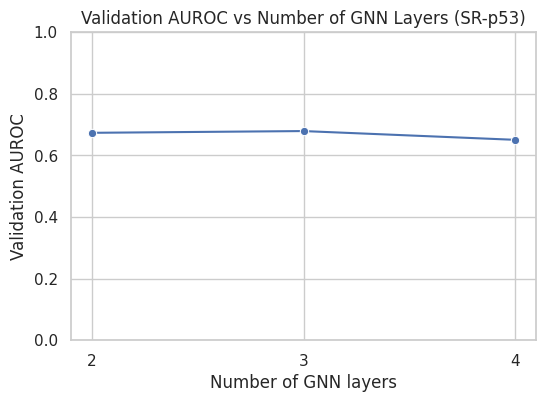

In [31]:
# Plot validation AUROC vs number of layers
plt.figure()
sns.lineplot(data=depth_df, x="n_layers", y="val_auroc", marker="o")
plt.title(f"Validation AUROC vs Number of GNN Layers ({TARGET_TASK_NAME})")
plt.xlabel("Number of GNN layers")
plt.ylabel("Validation AUROC")
plt.xticks(depth_df["n_layers"].unique())
plt.ylim(0.0, 1.0)
plt.show()



## 12. Hyperparameter Sweep 2: Dropout Rate

Fixed `n_layers = 3` and swept **dropout**:

- `n_layers = 3`
- `hidden_dim = 64`
- `embed_dim = 64`
- `lr = 1e-3`
- `weight_decay = 1e-5`
- `n_epochs = 10`
- `dropout ∈ {0.0, 0.2, 0.4}`


In [32]:
dropout_results = []

for dropout in [0.0, 0.2, 0.4]:
    print("\n========================================")
    print(f"Training GNN with dropout = {dropout}")
    print("========================================")
    model, val_metrics, test_metrics = train_gnn_model(
        n_layers=3,
        hidden_dim=64,
        embed_dim=64,
        dropout=dropout,
        lr=1e-3,
        weight_decay=1e-5,
        n_epochs=40
    )
    row = {
        "sweep": "dropout",
        "n_layers": 3,
        "dropout": dropout,
        "hidden_dim": 64,
        "lr": 1e-3,
        "weight_decay": 1e-5,
        "val_auroc": val_metrics["auroc"],
        "val_auprc": val_metrics["auprc"],
        "val_f1": val_metrics["f1"],
        "test_auroc": test_metrics["auroc"],
        "test_auprc": test_metrics["auprc"],
        "test_f1": test_metrics["f1"]
    }
    dropout_results.append(row)

dropout_df = pd.DataFrame(dropout_results)
dropout_df



Training GNN with dropout = 0.0
Epoch 01 | Loss=1.3000 | Val AUROC=0.5981 | Val F1=0.1563
Epoch 02 | Loss=1.2960 | Val AUROC=0.6271 | Val F1=0.1385
Epoch 03 | Loss=1.2882 | Val AUROC=0.6255 | Val F1=0.1467
Epoch 04 | Loss=1.2840 | Val AUROC=0.6081 | Val F1=0.1461
Epoch 05 | Loss=1.2798 | Val AUROC=0.6421 | Val F1=0.1314
Epoch 06 | Loss=1.2680 | Val AUROC=0.6875 | Val F1=0.1372
Epoch 07 | Loss=1.2536 | Val AUROC=0.6856 | Val F1=0.1670
Epoch 08 | Loss=1.2394 | Val AUROC=0.6599 | Val F1=0.1451
Epoch 09 | Loss=1.2502 | Val AUROC=0.6826 | Val F1=0.1395
Epoch 10 | Loss=1.2354 | Val AUROC=0.6915 | Val F1=0.1395
Epoch 11 | Loss=1.2269 | Val AUROC=0.6681 | Val F1=0.1333
Epoch 12 | Loss=1.2279 | Val AUROC=0.6511 | Val F1=0.1509
Epoch 13 | Loss=1.2287 | Val AUROC=0.6819 | Val F1=0.1776
Epoch 14 | Loss=1.2085 | Val AUROC=0.6697 | Val F1=0.1630
Epoch 15 | Loss=1.2034 | Val AUROC=0.6759 | Val F1=0.1566
Epoch 16 | Loss=1.2142 | Val AUROC=0.6660 | Val F1=0.1619
Epoch 17 | Loss=1.2109 | Val AUROC=0.67

,sweep,n_layers,dropout,hidden_dim,lr,weight_decay,val_auroc,val_auprc,val_f1,test_auroc,test_auprc,test_f1
0,dropout,3,0.0,64,0.001,0.00001,0.668651,0.116136,0.155440,0.617105,0.083092,0.165829
1,dropout,3,0.2,64,0.001,0.00001,0.678155,0.132541,0.158470,0.631089,0.087805,0.167116
2,dropout,3,0.4,64,0.001,0.00001,0.673770,0.132204,0.152672,0.646320,0.092239,0.163328


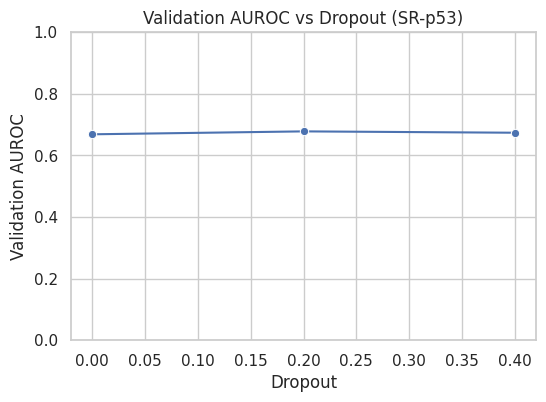

In [33]:
# Plot validation AUROC vs dropout
plt.figure()
sns.lineplot(data=dropout_df, x="dropout", y="val_auroc", marker="o")
plt.title(f"Validation AUROC vs Dropout ({TARGET_TASK_NAME})")
plt.xlabel("Dropout")
plt.ylabel("Validation AUROC")
plt.ylim(0.0, 1.0)
plt.show()



## 13. Baseline vs Best GNN Comparison

Compare:

- Logistic Regression baseline (ECFP/Morgan)
- Best GNN (over all hyperparameter configs) chosen by **validation AUROC**.


In [34]:
# Combine GNN sweep results
all_gnn_df = pd.concat([depth_df, dropout_df], ignore_index=True)

# Find best configuration by validation AUROC
best_idx = all_gnn_df["val_auroc"].idxmax()
best_row = all_gnn_df.loc[best_idx]
print("Best GNN configuration (by validation AUROC):")
print(best_row)

# Build comparison DataFrame using test metrics
comparison_rows = []

# Baseline: Logistic Regression
comparison_rows.append({
    "model": "LogReg (Morgan)",
    "n_layers": None,
    "dropout": None,
    "test_auroc": logreg_test_metrics["auroc"],
    "test_auprc": logreg_test_metrics["auprc"],
    "test_accuracy": logreg_test_metrics["accuracy"],
    "test_f1": logreg_test_metrics["f1"]
})

# Best GNN
comparison_rows.append({
    "model": "GNN (best)",
    "n_layers": int(best_row["n_layers"]),
    "dropout": float(best_row["dropout"]),
    "test_auroc": best_row["test_auroc"],
    "test_auprc": best_row["test_auprc"],
    "test_accuracy": None, 
    "test_f1": best_row["test_f1"]
})

comparison_df = pd.DataFrame(comparison_rows)
comparison_df


Best GNN configuration (by validation AUROC):
sweep           n_layers
n_layers               3
dropout              0.2
hidden_dim            64
lr                 0.001
weight_decay     0.00001
val_auroc       0.679172
val_auprc       0.130045
val_f1          0.158672
test_auroc      0.637326
test_auprc      0.089548
test_f1         0.156716
Name: 1, dtype: object


,model,n_layers,dropout,test_auroc,test_auprc,test_accuracy,test_f1
0,LogReg (Morgan),NaN,NaN,0.652639,0.182907,0.870079,0.223529
1,GNN (best),3.0,0.2,0.637326,0.089548,NaN,0.156716


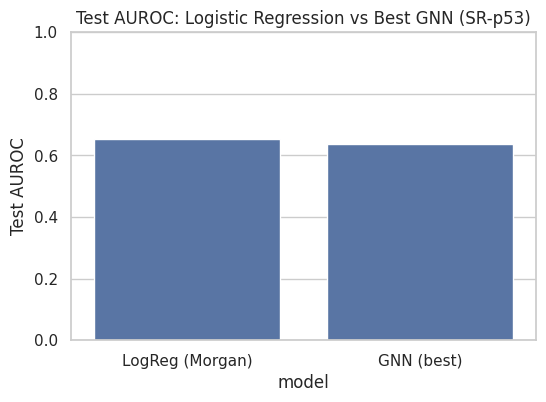

In [35]:
# Test AUROC baseline vs best GNN
plt.figure()
sns.barplot(data=comparison_df, x="model", y="test_auroc")
plt.title(f"Test AUROC: Logistic Regression vs Best GNN ({TARGET_TASK_NAME})")
plt.ylabel("Test AUROC")
plt.ylim(0.0, 1.0)
plt.show()



## 14. Export Tables 


In [36]:
output_dir = "./results_tables"
os.makedirs(output_dir, exist_ok=True)

depth_csv_path = os.path.join(output_dir, f"tox21_{TARGET_TASK_NAME}_gnn_depth_sweep.csv")
dropout_csv_path = os.path.join(output_dir, f"tox21_{TARGET_TASK_NAME}_gnn_dropout_sweep.csv")
comparison_csv_path = os.path.join(output_dir, f"tox21_{TARGET_TASK_NAME}_baseline_vs_gnn.csv")

depth_df.to_csv(depth_csv_path, index=False)
dropout_df.to_csv(dropout_csv_path, index=False)
comparison_df.to_csv(comparison_csv_path, index=False)

print("Saved tables:")
print("  Depth sweep      ->", depth_csv_path)
print("  Dropout sweep    ->", dropout_csv_path)
print("  Baseline vs GNN  ->", comparison_csv_path)


Saved tables:
  Depth sweep      -> ./results_tables/tox21_SR-p53_gnn_depth_sweep.csv
  Dropout sweep    -> ./results_tables/tox21_SR-p53_gnn_dropout_sweep.csv
  Baseline vs GNN  -> ./results_tables/tox21_SR-p53_baseline_vs_gnn.csv


## 15. Supplemental Figs

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

TARGET_TASK_NAME = "SR-p53"

# Change this if your CSVs are in a subfolder
results_dir = "."

depth_csv_path = "/content/results_tables/tox21_SR-p53_gnn_depth_sweep.csv"
dropout_csv_path = "/content/results_tables/tox21_SR-p53_gnn_dropout_sweep.csv"
comparison_csv_path = "/content/results_tables/tox21_SR-p53_baseline_vs_gnn.csv"

depth_df = pd.read_csv(depth_csv_path)
dropout_df = pd.read_csv(dropout_csv_path)
comparison_df = pd.read_csv(comparison_csv_path)

depth_df.head(), dropout_df.head(), comparison_df.head()


(      sweep  n_layers  dropout  hidden_dim     lr  weight_decay  val_auroc  \
 0  n_layers         2      0.2          64  0.001       0.00001   0.673503   
 1  n_layers         3      0.2          64  0.001       0.00001   0.679172   
 2  n_layers         4      0.2          64  0.001       0.00001   0.650760   
 
    val_auprc    val_f1  test_auroc  test_auprc   test_f1  
 0   0.122135  0.155902    0.614463    0.084208  0.141509  
 1   0.130045  0.158672    0.637326    0.089548  0.156716  
 2   0.114487  0.156398    0.621504    0.088295  0.157044  ,
      sweep  n_layers  dropout  hidden_dim     lr  weight_decay  val_auroc  \
 0  dropout         3      0.0          64  0.001       0.00001   0.668651   
 1  dropout         3      0.2          64  0.001       0.00001   0.678155   
 2  dropout         3      0.4          64  0.001       0.00001   0.673770   
 
    val_auprc    val_f1  test_auroc  test_auprc   test_f1  
 0   0.116136  0.155440    0.617105    0.083092  0.165829  
 1   0.

## 15.1 Validation AUROC vs number of GraphConv layers

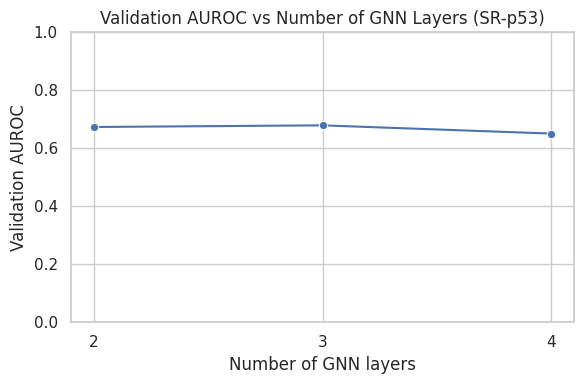

In [39]:
plt.figure()
sns.lineplot(
    data=depth_df,
    x="n_layers",
    y="val_auroc",
    marker="o"
)
plt.title(f"Validation AUROC vs Number of GNN Layers ({TARGET_TASK_NAME})")
plt.xlabel("Number of GNN layers")
plt.ylabel("Validation AUROC")
plt.xticks(sorted(depth_df["n_layers"].unique()))
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()


## 15.2 Validation AUROC vs dropout

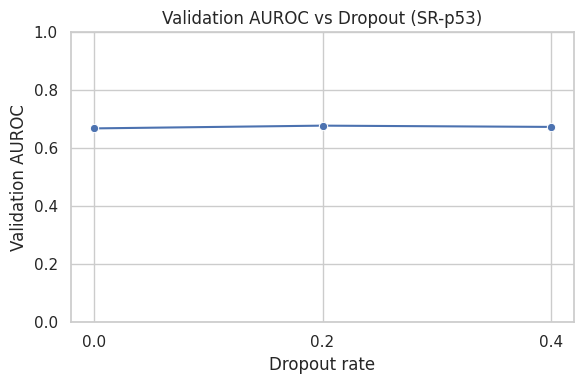

In [40]:
plt.figure()
sns.lineplot(
    data=dropout_df,
    x="dropout",
    y="val_auroc",
    marker="o"
)
plt.title(f"Validation AUROC vs Dropout ({TARGET_TASK_NAME})")
plt.xlabel("Dropout rate")
plt.ylabel("Validation AUROC")
plt.xticks(sorted(dropout_df["dropout"].unique()))
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()
